In [1]:
import numpy as np
import scipy.sparse
import pandas as pd
pd.set_option("display.max_columns", None)
import time
import datetime
from sklearn import metrics
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix
import tensorflow as tf
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import tensorflow_transform as tft

from tqdm import tqdm
tqdm.pandas()

In [2]:
from google.cloud import bigquery
import gcsfs

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: res-nbcupea-dev-ds-sandbox-001


In [3]:
def focal_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.75, gamma=3.0)


In [4]:
# Load the model
model_path = {}
model_path["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23992/serving_model_dir"
model_path["concat_both"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23973/serving_model_dir"
model_path["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23984/serving_model_dir"
#model = tf.saved_model.load(model_path)

In [5]:
# Load the vocab
tags_list_dict = {}
tags_list_dict["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23971/transform_fn/assets/tags"
tags_list_dict["concat_both"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23971/transform_fn/assets/tags"
tags_list_dict["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23971/transform_fn/assets/tags"
fs = gcsfs.GCSFileSystem(project="res-nbcupea-dev-ds-sandbox-001")
for key, path in tags_list_dict.items():
    if path == "": continue
    with fs.open(path, "r") as fid:
        tags_list = fid.read().split("\n")
    tags_list = [tag for tag in tags_list if tag != ""]
    tags_list_dict[key] = tags_list
tags_list

['Movie',
 'eng',
 'spa',
 'Drama',
 'Episode',
 'Action & Adventure',
 'Comedy',
 'Documentary',
 'Thriller',
 'Local',
 'Horror',
 'Romance',
 'Comedy drama',
 "Children's/Family Entertainment",
 'Crime drama',
 'Fantasy',
 'Animated',
 'Mystery',
 'Science fiction',
 'Sports',
 'Reality',
 'Western',
 'Entertainment',
 'Special',
 'Romance comedy',
 'Music',
 'Sports non-event',
 'Biography',
 'Independent',
 'Holiday',
 'Crime',
 'Military & War',
 'Religion',
 'older teens (ages 15+)',
 'Musical',
 'History drama',
 'Documentary drama',
 'History',
 'Shopping',
 'Educational',
 'kids (ages 5-9)',
 'teens (ages 13-14)',
 'Talk',
 'Travel',
 'Public Affairs',
 'Gay and Lesbian',
 'Foreign',
 'Food',
 'Animals',
 'Nature',
 'tweens (ages 10-12)',
 'News',
 'Miniseries',
 'Teens',
 'Martial arts',
 'Science & Technology',
 'Anime',
 'Courtroom',
 'Health',
 'Musical comedy',
 'Sitcom',
 'Outdoors',
 'Interview',
 'Variety',
 'Home & Garden',
 'Fashion',
 'Christmas',
 'Soccer',
 'Wedd

# Inspect training data only

In [6]:
query = """SELECT ROW_NUMBER() OVER() row_number, program_title, LOWER(program_title) AS title, program_type, 
    program_longsynopsis AS synopsis, tags
FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.synopsis_dylan_150tag_with_tokens_and_keywords`
LIMIT 50000
"""

df_train = client.query(query).to_dataframe()
df_train

,row_number,program_title,title,program_type,synopsis,tags
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]"
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]"
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]"
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]"
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]"
...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]"
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]"
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]"
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]"


In [7]:
# translate tags back into multi-hot labels
def tags_to_index(tags, tags_list):
    col = np.array([tags_list.index(t) for t in tags], dtype=int)
    data = np.ones(len(col), dtype=int)
    row = np.zeros(len(col), dtype=int)
    return coo_matrix((data, (row, col)), shape=(1, len(tags_list))).A[0]

for key in model_path.keys():
    df_train[f"labels_{key}"] = df_train["tags"].progress_apply(lambda x: tags_to_index(x, tags_list_dict[key]))
df_train

100%|██████████| 50000/50000 [00:02<00:00, 16788.00it/s]


,row_number,program_title,title,program_type,synopsis,tags,labels_concat_before,labels_concat_both,labels_concat_after
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
# Make predictions
input_data = {"synopsis": df_train['synopsis'].values[:, None], 
              "title": df_train["title"].values[:, None],
 }
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
    
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_train[f"{key}_predicted"] = res
    # Temporarily save the results
    df_train.to_pickle("./scratch/explore_emd_08_train_predicted_values.pkl", compression="gzip")

df_train


Loading model: concat_before


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


Loading model: concat_both


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:29<00:00,  4.76it/s]


Loading model: concat_after


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]


,row_number,program_title,title,program_type,synopsis,tags,labels_concat_before,labels_concat_both,labels_concat_after,concat_before_predicted,concat_both_predicted,concat_after_predicted
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.9001042, 0.0719494, 0.94875425, 0.07661556,...","[0.9154786, 0.08678742, 0.9545608, 0.0547881, ...","[0.8399583, 0.15484232, 0.9305561, 0.5272072, ..."
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.907768, 0.9685476, 0.029314572, 0.18396245,...","[0.8579384, 0.9614297, 0.052606214, 0.13819231...","[0.7798332, 0.9694156, 0.054464713, 0.56173825..."
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0.81734633, 0.10981821, 0.95617867, 0.1932480...","[0.825568, 0.16697527, 0.9602953, 0.15370637, ...","[0.7221812, 0.21305256, 0.9422407, 0.5191253, ..."
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.8386849, 0.95484596, 0.15374781, 0.13427857...","[0.8265061, 0.9571939, 0.14757037, 0.10348968,...","[0.63709074, 0.9635184, 0.1930505, 0.3817455, ..."
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.88508266, 0.08397366, 0.954612, 0.61709917,...","[0.8890446, 0.10791818, 0.961816, 0.5585374, 0...","[0.8730372, 0.12966627, 0.930998, 0.5626992, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9139574, 0.9586899, 0.036939878, 0.28291556...","[0.9191333, 0.9542796, 0.05406696, 0.27636296,...","[0.85148126, 0.9537923, 0.049367707, 0.5434665..."
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9025014, 0.09135432, 0.91870004, 0.98948205...","[0.94658107, 0.10690971, 0.94431925, 0.9856054...","[0.8768848, 0.12123837, 0.93000066, 0.5471485,..."
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9611464, 0.09017987, 0.9320659, 0.17800158,...","[0.95988005, 0.12469927, 0.9324976, 0.15616894...","[0.84582293, 0.1694934, 0.92561674, 0.514115, ..."
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]","[0, 1, 0, 1, 1, 0, 0, 0

In [11]:
df_train = pd.read_pickle("./scratch/explore_emd_08_train_predicted_values.pkl", compression="gzip")
df_train

,row_number,program_title,title,program_type,synopsis,tags,labels_concat_before,labels_concat_both,labels_concat_after,concat_before_predicted,concat_both_predicted,concat_after_predicted
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.8934669, 0.06632726, 0.95952654, 0.10030515...","[0.9070418, 0.06420858, 0.9550103, 0.09028389,...","[0.8253068, 0.12199429, 0.9541529, 0.5386213, ..."
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.8585604, 0.9404377, 0.04779131, 0.16191141,...","[0.8843223, 0.96550614, 0.043165814, 0.1640907...","[0.7824883, 0.9678829, 0.07003368, 0.56689805,..."
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0.81275606, 0.09641536, 0.96398777, 0.2381546...","[0.83753866, 0.10547957, 0.9587806, 0.20073584...","[0.7222696, 0.15386403, 0.96060145, 0.53743327..."
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.74899364, 0.90237004, 0.23544739, 0.1321258...","[0.7754286, 0.95119095, 0.22058079, 0.1296872,...","[0.59603435, 0.95589626, 0.21881342, 0.3977266..."
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.88985103, 0.07059304, 0.95813674, 0.6458064...","[0.86593497, 0.08458795, 0.958798, 0.6076865, ...","[0.8682472, 0.106376745, 0.95762813, 0.5779175..."
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9292693, 0.952023, 0.066356145, 0.3037845, ...","[0.910924, 0.95824075, 0.043018248, 0.3042492,...","[0.82836425, 0.94802564, 0.05877439, 0.530228,..."
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9270017, 0.066873714, 0.9442661, 0.99188846...","[0.9232281, 0.07477001, 0.9282448, 0.9857341, ...","[0.87275904, 0.09121653, 0.9521636, 0.5628774,..."
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9658848, 0.08058406, 0.9439644, 0.212059, 0...","[0.95162, 0.08855511, 0.94172895, 0.1954994, 0...","[0.8397483, 0.13116412, 0.95538336, 0.54482675..."
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]","[0, 1, 0, 1, 1, 0, 0, 0

In [9]:
## Binary classifier precision and recall ROC
classifier_metrics = {"concat_before": {"pr_auc": [], "roc_auc":[], "accuracy":[]},
                      "concat_both":   {"pr_auc": [], "roc_auc":[], "accuracy":[]},
                      "concat_after":   {"pr_auc": [], "roc_auc":[], "accuracy":[]},
                     }
labels = np.stack(df_train["labels_concat_before"]).astype(int)

# Looping over model
for key in classifier_metrics:
    predicted_score = np.stack(df_train[f"{key}_predicted"])
    predicted_binary = (predicted_score > 0.5).astype(int)
    # Looping over tags / vector
    for t in tqdm(range(labels.shape[1])):
        if np.all(labels[:, t] < 1E-3):
            accuracy, pr_auc, roc_auc = -1, -1, -1
        elif  np.all(labels[:, t]==1):
            accuracy, pr_auc, roc_auc = 10, 10, 10
        else:
            accuracy = (predicted_binary[:, t] == labels[:, t]).mean()
            pr_auc = metrics.average_precision_score(labels[:, t], predicted_score[:, t])
            roc_auc = metrics.roc_auc_score(labels[:, t], predicted_score[:, t])

        classifier_metrics[key]["accuracy"].append(accuracy)
        classifier_metrics[key]["pr_auc"].append(pr_auc)
        classifier_metrics[key]["roc_auc"].append(roc_auc)
    classifier_metrics[key]["percent_pos_labels"] = labels.mean(axis=0)



100%|██████████| 146/146 [00:03<00:00, 42.85it/s]


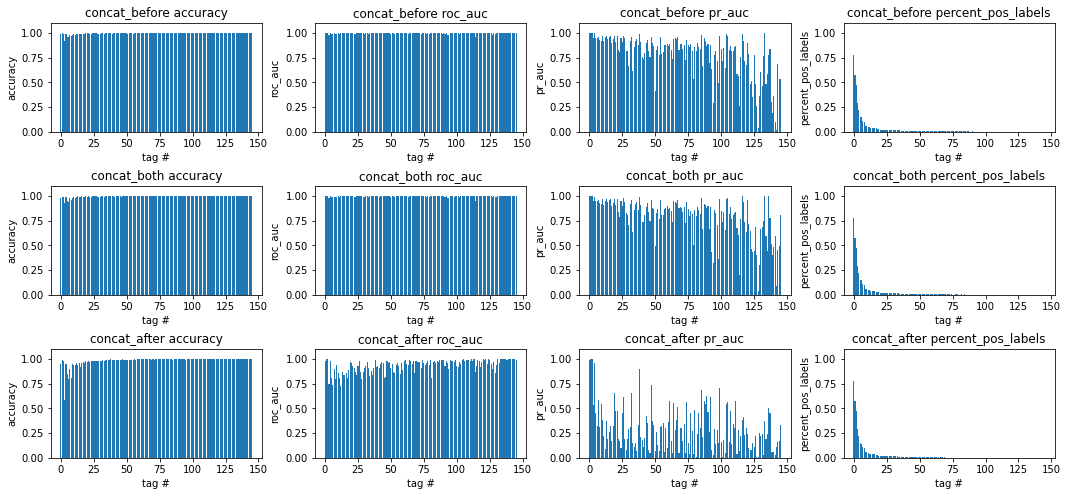

In [10]:
# Plot out the performance of classifier
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 4, figsize=(18, 8))

for j, key in enumerate(classifier_metrics.keys()):
    classifier_metrics[key]["percent_pos_labels"] = labels.mean(axis=0)
    for i, m in enumerate(["accuracy", "roc_auc", "pr_auc", "percent_pos_labels"]):
        ax = axs[j, i]
        ax.bar(np.arange(len(classifier_metrics[key][m])), classifier_metrics[key][m])
        ax.set_title(f"{key} {m}")
        ax.set_xlabel("tag #")
        ax.set_ylabel(m)
        ax.set_ylim(0, 1.1)
        
fig.subplots_adjust(wspace=0.25, hspace=0.5)


# Evaluation on the content-to-content recommendations

In [11]:
TITLES_QUERY_titles = """
    WITH titles_data AS (
        SELECT DISTINCT
            TitleDetails_title, 
            TitleType, 
            cid.content_ordinal_id,
            STRING_AGG(DISTINCT TitleDetails_longsynopsis, ' ') as TitleDetails_longsynopsis,
        FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.ContentMetadataView` cmv
        LEFT JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentOrdinalId` cid
            ON LOWER(cmv.TitleDetails_title) = LOWER(cid.program_title)
        WHERE 
            TitleDetails_longsynopsis IS NOT NULL
            AND cid.content_ordinal_id IS NOT NULL
        GROUP BY 
            TitleDetails_title, 
            TitleType,
            cid.content_ordinal_id
        )
    SELECT TitleDetails_title, LOWER(TitleDetails_title) AS title, TitleType, content_ordinal_id, TitleDetails_longsynopsis, 
    FROM titles_data
"""
df_titles = client.query(TITLES_QUERY_titles) \
                        .to_dataframe() \
                        .drop_duplicates(subset=['TitleDetails_title']) \
                        .reset_index(drop=True)

    
df_titles

,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b..."
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...
...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Programme,1913,"Tara Lipinski,1998 Olympic gold medalist, and ..."


In [12]:
input_data = {"synopsis": df_titles['TitleDetails_longsynopsis'].values[:, None], 
              "title": df_titles['TitleDetails_longsynopsis'].values[:, None]}
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
   
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_titles[f"{key}_predicted"] = res
    # Temporarily save the results
    df_titles.to_pickle("./scratch/explore_emd_08_titles_predicted_values.pkl", compression="gzip")

df_titles


Loading model: concat_before


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


Loading model: concat_both


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


Loading model: concat_after


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:10<00:00,  4.21it/s]


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.81644434, 0.90579253, 0.15320522, 0.4928113...","[0.8284041, 0.905096, 0.20058607, 0.45802736, ...","[0.8212801, 0.8854742, 0.16610035, 0.4262186, ..."
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.7035422, 0.9863275, 0.08182001, 0.49750206,...","[0.71488655, 0.98637944, 0.12275929, 0.4590722...","[0.71639156, 0.97941005, 0.15130031, 0.5399029..."
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.8400246, 0.9725601, 0.061443575, 0.60232407...","[0.8737767, 0.97333544, 0.11291292, 0.570399, ...","[0.85491306, 0.9705054, 0.0812858, 0.59130585,..."
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.7750384, 0.97071934, 0.15157142, 0.5666047,...","[0.7901433, 0.97014254, 0.19608684, 0.54323006...","[0.7899858, 0.97068393, 0.1514504, 0.57636464,..."
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.88433164, 0.97341317, 0.05437197, 0.5938839...","[0.90864223, 0.97640926, 0.073455505, 0.545751...","[0.8962843, 0.9673246, 0.08035563, 0.58995014,..."
...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5537927, 0.9188018, 0.070349395, 0.3195026,...","[0.5911677, 0.9400158, 0.06304189, 0.27550107,...","[0.49115136, 0.9172866, 0.09860793, 0.46767575..."
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.82637185, 0.9665248, 0.069342524, 0.5267624...","[0.83089155, 0.9676499, 0.10530832, 0.49927768...","[0.8325111, 0.96192795, 0.09974488, 0.583066, ..."
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...,"[0.7483167, 0.9380821, 0.14303333, 0.5546146, ...","[0.7717945, 0.9442298, 0.18063933, 0.48663375,...","[0.75308955, 0.9254806, 0.17458522, 0.5577479,..."
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Programme,1913,"Tara Lipinski,1998 Olympic gold medalist, and ...","[0.79096526, 0.8980153, 0.07218288, 0.45349768...","[0.8372948, 0.8921809, 0.10497185, 0.4276667, ...","[0.772042, 0.88780344, 0.10814912, 0.36288315,..."


## Plot the embeddings of some titles

In [13]:
important_titles = ["The Office", "30 Rock", "Punky Brewster", "Parks and Recreation", "WWE Monday Night RAW", 
            "Yellowstone", "Saturday Night Live", "Law & Order: Special Victims Unit", 
            "Law & Order: Organized Crime", "Mr. Mercedes", "Happy Feet Two", "Zombie Tidal Wave"]

key_tags = ["eng", "spa",
            'preschoolers (ages 2-4)', 'kids (ages 5-9)', 'tweens (ages 10-12)','teens (ages 13-14)',
            'older teens (ages 15+)','not for kids',
            "Action & Adventure", "Comedy","Horror", "Children's/Family Entertainment", "Sports", 
            "Animated", "Holiday", "Crime", 'News', 'Reality', 'Music', 'Christmas','Food','Travel','Fantasy',
            'Science fiction','History',
           ]

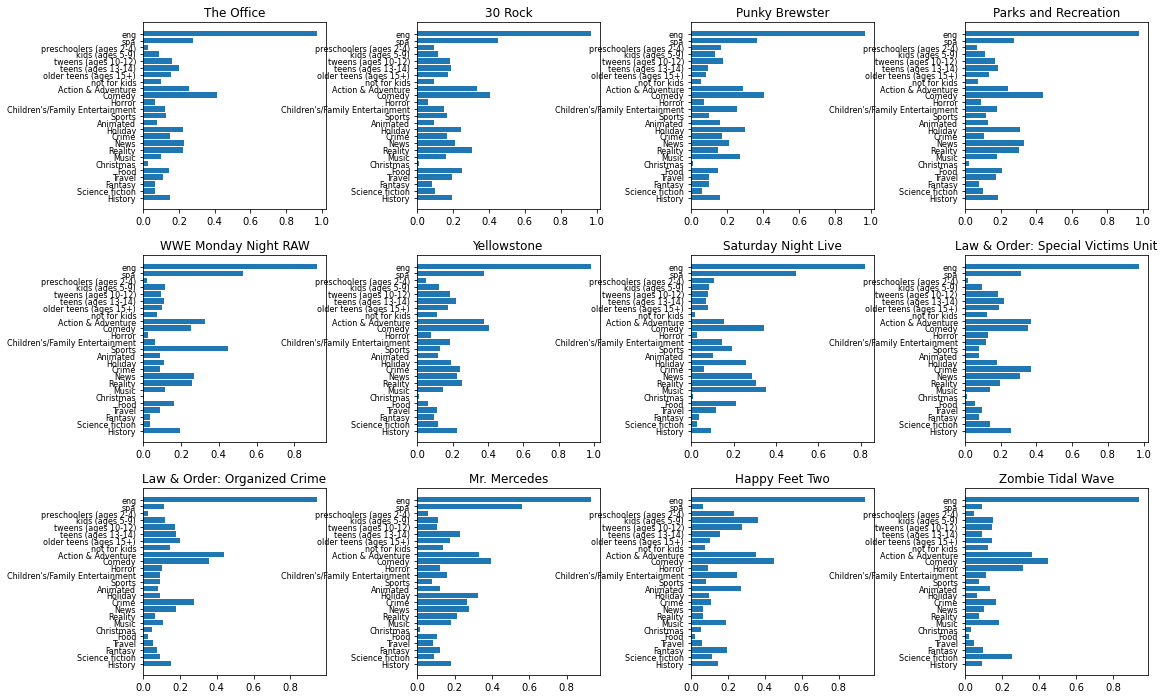

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()

key = "concat_before"
indices = [tags_list_dict[key].index(aa) for aa in key_tags]

for i, (ax, ti) in enumerate(zip(axs, important_titles)):
    values = np.take(df_titles.loc[df_titles["TitleDetails_title"] == ti, f"{key}_predicted"].values[0], 
                     indices)
    ax.barh(np.arange(25), values)
    ax.set_title(ti)
    ax.set_yticks(np.arange(25))
    ax.set_yticklabels(key_tags, fontsize=8)
    ax.invert_yaxis()

fig.subplots_adjust(wspace=0.5, hspace=0.25)

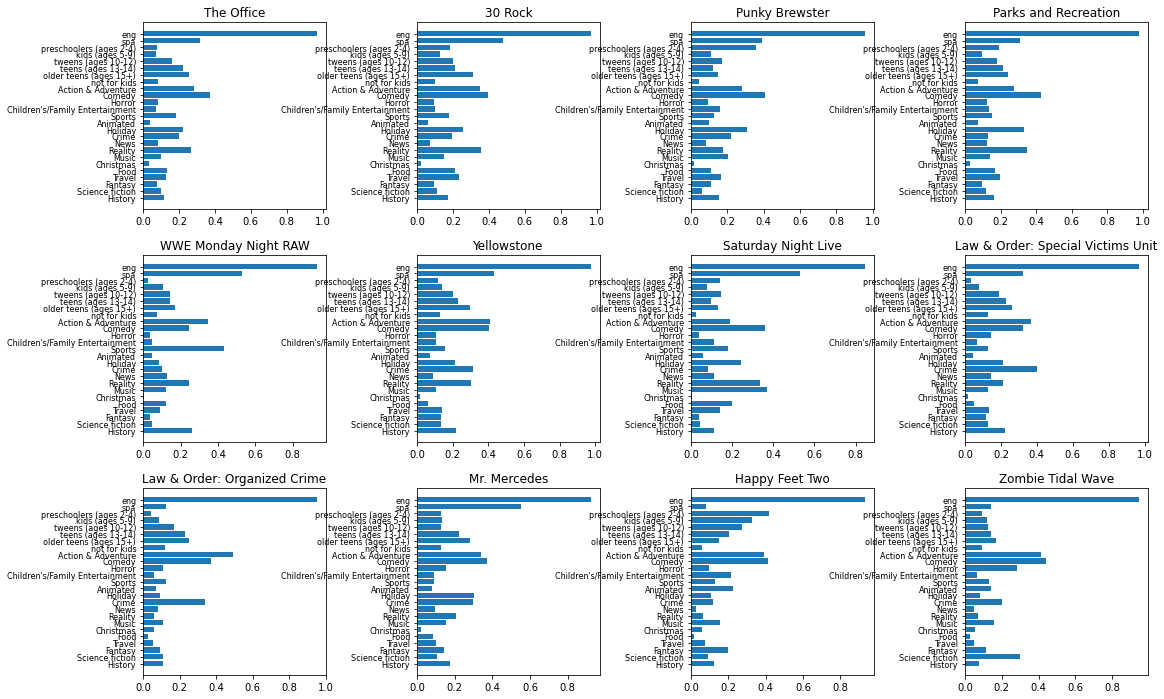

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()

key = "concat_both"
indices = [tags_list_dict[key].index(aa) for aa in key_tags]

for i, (ax, ti) in enumerate(zip(axs, important_titles)):
    values = np.take(df_titles.loc[df_titles["TitleDetails_title"] == ti, f"{key}_predicted"].values[0], 
                     indices)
    ax.barh(np.arange(25), values)
    ax.set_title(ti)
    ax.set_yticks(np.arange(25))
    ax.set_yticklabels(key_tags, fontsize=8)
    ax.invert_yaxis()

fig.subplots_adjust(wspace=0.5, hspace=0.25)

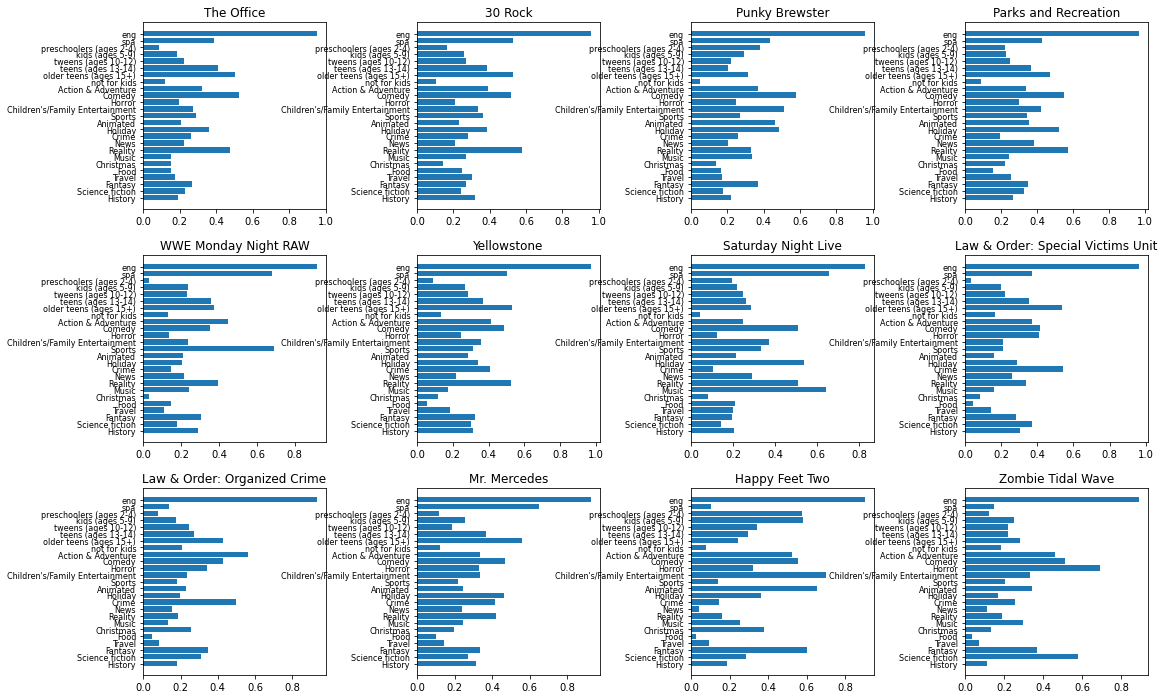

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()

key = "concat_after"
indices = [tags_list_dict[key].index(aa) for aa in key_tags]

for i, (ax, ti) in enumerate(zip(axs, important_titles)):
    values = np.take(df_titles.loc[df_titles["TitleDetails_title"] == ti, f"{key}_predicted"].values[0], 
                     indices)
    ax.barh(np.arange(25), values)
    ax.set_title(ti)
    ax.set_yticks(np.arange(25))
    ax.set_yticklabels(key_tags, fontsize=8)
    ax.invert_yaxis()

fig.subplots_adjust(wspace=0.5, hspace=0.25)

In [25]:
df_titles = pd.read_pickle("./scratch/explore_emd_08_titles_predicted_values.pkl", compression="gzip")
df_titles

,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.82572275, 0.8620805, 0.20260306, 0.5442321,...","[0.8101622, 0.89531285, 0.14627147, 0.46928272..."
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.6745518, 0.97476304, 0.13806131, 0.5251195,...","[0.6965991, 0.97596323, 0.086428136, 0.4783468..."
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.85344374, 0.96640146, 0.092651814, 0.677004...","[0.86821437, 0.95883435, 0.07281119, 0.6060896..."
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.74991864, 0.9447019, 0.24710113, 0.63034356...","[0.757171, 0.95129824, 0.18187079, 0.56932473,..."
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.87171704, 0.9651357, 0.08164043, 0.6201653,...","[0.88818765, 0.9599676, 0.06208499, 0.56803215..."
...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5145462, 0.9096455, 0.10418529, 0.33951396,...","[0.5480638, 0.91077423, 0.07880795, 0.32602242..."
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.8116353, 0.9475964, 0.11782857, 0.57066345,...","[0.7899944, 0.95454454, 0.079050995, 0.5353836..."
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...,"[0.74996185, 0.9209636, 0.22169153, 0.5933068,...","[0.77825755, 0.9172044, 0.19623227, 0.53398424..."
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Programme,1913,"Tara Lipinski,1998 Olympic gold medalist, and ...","[0.7916899, 0.8176312, 0.091527864, 0.44676372...","[0.8104488, 0.880476, 0.07214383, 0.4369234, 0..."


## Making Content to content recommendations

In [39]:
# Do the pairwise similarity
def cosine_sim(P):
    P = P / np.sqrt(np.sum(P**2, axis=1, keepdims=True))
    cos_sim_c2c = P @ P.T
    cos_sim_c2c = np.nan_to_num(cos_sim_c2c, nan=-1)
    return cos_sim_c2c

def kl_divergence(P):
    P = P / np.sum(P, axis=1, keepdims=True)
    H_p = -np.sum(P * np.log(P), axis=1, keepdims=True)
    H_p_q = -(P @ np.log(P.T))
    D_kl = H_p_q - H_p
    return D_kl

def js_divergence(P):
    D_kl = kl_divergence(P)
    return D_kl * 0.5 + D_kl.T * 0.5

similarity = {"cosine":{}}

for s in similarity:
    for key in model_path.keys():
        predicted = np.stack(df_titles[f"{key}_predicted"].values)
        similarity[s][key] = cosine_sim(predicted)
        
        # Slice out top 15 recommendations
        score = list(np.sort(similarity[s][key], axis=1)[:, ::-1][:, 1:(15+1)])
        sim_c2c_argsort = np.argsort(similarity[s][key], axis=1)[:, ::-1][:, 1:]
        titles = list(np.take(df_titles["TitleDetails_title"].values, sim_c2c_argsort[:, :15]))
        titles_type = list(np.take(df_titles["TitleType"].values, sim_c2c_argsort[:, :15]))
        synopsis = list(np.take(df_titles["TitleDetails_longsynopsis"].values, sim_c2c_argsort[:, :15]))
        content_id = list(np.take(df_titles["content_ordinal_id"].values, sim_c2c_argsort[:, :15]))
        dict_list = [{"TitleDetails_title": tt, "TitleType": ttype, "TitleDetails_longsynopsis": syn, "content_ordinal_id": cid, "score": sc} \
                     for tt, ttype, syn, cid, sc in zip(titles, titles_type, synopsis, content_id, score)]

        df_titles[f"{s}_{key}_top15"] = dict_list
        # Calculate a type match
        df_titles[f"{s}_{key}_type_match"] = (np.stack(titles_type) == df_titles["TitleType"][:, None]).mean(axis=1)
        
df_titles

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted,cosine_concat_before_top15,cosine_concat_before_type_match,cosine_concat_both_top15,cosine_concat_both_type_match,cosine_concat_after_top15,cosine_concat_after_type_match,concat_before_x,concat_before_y,concat_both_x,concat_both_y,concat_after_x,concat_after_y
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.81644434, 0.90579253, 0.15320522, 0.4928113...","[0.8284041, 0.905096, 0.20058607, 0.45802736, ...","[0.8212801, 0.8854742, 0.16610035, 0.4262186, ...",{'TitleDetails_title': ['Joel McHale: Live Fro...,1.000000,"{'TitleDetails_title': ['I Am Big Bird', 'The ...",1.000000,{'TitleDetails_title': ['The Kentucky Fried Mo...,1.000000,11.166300,-15.652939,7.383417,8.870411,18.750639,15.245512
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.7035422, 0.9863275, 0.08182001, 0.49750206,...","[0.71488655, 0.98637944, 0.12275929, 0.4590722...","[0.71639156, 0.97941005, 0.15130031, 0.5399029...","{'TitleDetails_title': ['Zombie Night', 'Curse...",1.000000,"{'TitleDetails_title': ['Brother's Keeper', 'W...",1.000000,"{'TitleDetails_title': ['Neds', 'Coldwater', '...",1.000000,-18.692150,14.555692,-12.044270,14.903689,-22.114405,-10.628927
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.8400246, 0.9725601, 0.061443575, 0.60232407...","[0.8737767, 0.97333544, 0.11291292, 0.570399, ...","[0.85491306, 0.9705054, 0.0812858, 0.59130585,...",{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,18.267637,-9.310962,4.476210,2.953112,9.003719,23.940203
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.7750384, 0.97071934, 0.15157142, 0.5666047,...","[0.7901433, 0.97014254, 0.19608684, 0.54323006...","[0.7899858, 0.97068393, 0.1514504, 0.57636464,...","{'TitleDetails_title': ['Midnight Lace', 'The ...",1.000000,"{'TitleDetails_title': ['Midnight Lace', 'Raw ...",1.000000,"{'TitleDetails_title': ['Primary Colors', 'Edi...",1.000000,-13.410742,12.958163,9.308162,-24.759205,-1.434509,-0.093949
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.88433164, 0.97341317, 0.05437197, 0.5938839...","[0.90864223, 0.97640926, 0.073455505, 0.545751...","[0.8962843, 0.9673246, 0.08035563, 0.58995014,...","{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,17.546431,42.870502,-5.715060,-44.866188,-34.406223,22.046257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5537927, 0.9188018, 0.070349395, 0.3195026,...","[0.5911677, 0.9400158, 0.06304189, 0.27550107,...","[0.49115136, 0.9172866, 0.09860793, 0.46767575...",{'TitleDetails_title': ['It's Not Halloween Wi...,1.000000,{'TitleDetails_title': ['It's Not Halloween Wi...,1.000000,"{'TitleDetails_title': ['Kannon Camera', 'Moet...",1.000000,-12.032392,-32.343018,-2.053887,30.473394,20.493658,-19.536478
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.82637185, 0.9665248, 0.069342524, 0.5267624...","[0.83089155, 0.9676499, 0.10530832, 0.49927768...","[0.8325111, 0.96192795, 0.09974488, 0.583066, ...","{'TitleDetails_title': ['Dial a Prayer', 'Back...",0.066667,"{'TitleDetails_title': ['Always Woodstock', 'E...",0.066667,"{'TitleDetails_title': ['Emily & Tim', 'Cry Fr...",0.066667,4.951672,-9.890123,11.920401,8.597969,12.310746,3.074100
2268,To All the Pineapples We've Loved Before,to all 

## Plotting out the distribution of cosine similarities

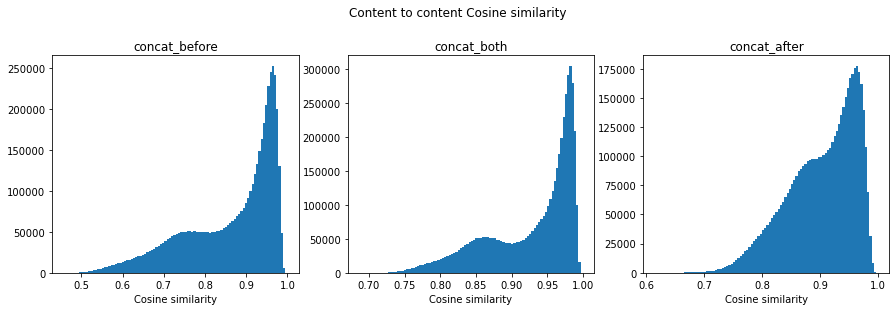

In [40]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, key in enumerate(model_path.keys()):
    ax = axs[i]
    ax.hist(np.sort(similarity["cosine"][key], axis=1)[:, ::-1][:, 1:].ravel(), bins=100) # remove cosine-sim with itself
    ax.set_xlabel("Cosine similarity")
    ax.set_title(key)
    
_ = fig.suptitle("Content to content Cosine similarity", y=1.05)

## Query some shows

In [41]:
# Do some quries
from IPython.display import display
def query_shows_c2c(df_titles, show_name, key="concat_after", sim_metric="cosine", show_res=True):
    pdf = df_titles.loc[df_titles["TitleDetails_title"]==show_name, :]
    pdf_query = pdf[["content_ordinal_id", "TitleDetails_title", "TitleType", "TitleDetails_longsynopsis"]]
    pdf_res = pd.DataFrame(pdf[f"{sim_metric}_{key}_top15"].values[0])
    if show_res:
        print("Query")
        display(pdf_query)
        print(f"Result: {sim_metric} {key}")
        display(pdf_res)
    
    return pdf_query, pdf_res
    

In [42]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_before")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Saved by the Bell,Programme,Zack's (Mark-Paul Gosselaar) latest moneymakin...,695,0.984806
1,The King of Queens,Programme,After learning that a wedding reception is fiv...,880,0.983669
2,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.982073
3,Intelligence,Programme,When the National Health Service's systems are...,1049,0.981499
4,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.981464
5,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.981420
6,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.981348
7,Father Knows Best,Programme,The Anderson children enter an essay into a co...,1914,0.981319
8,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.981203
9,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.980180


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1745,17,30 Rock,Programme,Jack tries to take back a drunken New Year's E...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.989878
1,Shahs of Sunset,Programme,Reality sets in for Reza as he faces the truth...,720,0.988312
2,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.987377
3,WAGS: Miami,Programme,Hencha goes ballistic when Faven sets up Astri...,993,0.987086
4,New Amsterdam,Programme,The recipient of Max's sister's heart arrives ...,598,0.986285
5,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.986278
6,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.986100
7,Five Bedrooms,Programme,Liz drowns her sorrows alone; Harry has a crus...,1199,0.985026
8,Flipping Out,Programme,The countdown to the baby's due date leaves no...,360,0.984937
9,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.984532


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1851,656,Punky Brewster,Programme,Punky creates chaos at the restaurant after He...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.985446
1,Little House on the Prairie,Programme,A farm boy (Mitch Vogel) takes Mr. Edward's ta...,1870,0.981756
2,Father Knows Best,Programme,The Anderson children enter an essay into a co...,1914,0.981620
3,Postman Pat: Special Delivery Service,Programme,Pat's mission is to deliver a family of hibern...,1201,0.981459
4,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.980946
5,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.980937
6,George Lopez,Programme,George and Benny try to fill jailed Jim's spot...,379,0.980783
7,Nina's World,Programme,When Nina discovers a lone flower growing in a...,1423,0.980531
8,My Life Me,Programme,Raffi's art show win hurtles Birch through the...,1146,0.980496
9,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.980225


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,"Leslie and Ben start new jobs; Donna, April an..."


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.988173
1,Mr. Robinson,Programme,Disgusted with Ben's sloppiness and lack of em...,1978,0.986751
2,Father of the Pride,Programme,"Overworked and feeling stressed, Larry takes a...",341,0.985097
3,Bethenny Ever After,Programme,Bethenny's business flourishes; Bethenny takes...,157,0.984658
4,The Real Housewives of New Jersey,Programme,Teresa manages her daughter's acting career wh...,1310,0.984295
5,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.982935
6,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.982660
7,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.982537
8,Modern Family,Programme,"Jay's ex-wife, Dede (Shelley Long), tries to m...",2036,0.982206
9,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.982114


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2047,2301,WWE Monday Night RAW,Programme,Shawn Michaels vs. Marty Jannetty. Ahmed Johns...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.992448
1,WWE NXT,Programme,"The NXT Championship is on the line, when Alei...",2341,0.987814
2,WWE Friday Night SmackDown,Programme,King Corbin promises to humiliate Roman Reigns...,2292,0.986594
3,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.985212
4,WrestleMania Rewind,Programme,John Cena against The Big Show from WrestleMan...,1211,0.980054
5,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.976455
6,WWE The Bump,Programme,Bobby Lashley and WWE Women's Tag Team Champio...,2363,0.972741
7,WWE Ruthless Aggression,Programme,Relive the formation of Evolution and triumphs...,1216,0.970794
8,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.967056
9,The Titan Games,Programme,Olympic snowboarder Hannah Teter and UFC champ...,935,0.966245


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1797,1017,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.987886
1,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.986252
2,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.986004
3,Swedish Dicks,Programme,When a movie star hires the detective agency t...,786,0.985090
4,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.984994
5,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.983276
6,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.983240
7,Sacred Lies: The Singing Bones,Programme,Peter shares the end of the story with Elsie; ...,1225,0.983140
8,Noughts + Crosses,Programme,When the McGregor family receives life-changin...,1272,0.983078
9,The Affair,Programme,Noah and Alison grow closer when they take a d...,1072,0.982896


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1582,693,Saturday Night Live,Programme,A compilation of skits salutes actor Dan Aykro...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,TV host RuPaul; Meghan Trainor talks and perfo...,936,0.990045
1,The Kelly Clarkson Show,Programme,"Kelly's video ""Just Sing""; Sherri Shepherd and...",878,0.977409
2,It's Showtime at the Apollo,Programme,Soul IV Real; Big Daddy Kane; comic Dugar. Ger...,2084,0.976462
3,Late Night With Seth Meyers,Programme,Actor John Cena; actress Gugu Mbatha-Raw; Bren...,503,0.969934
4,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.967421
5,The At-Home Variety Show Featuring Seth MacFar...,Programme,"Act 1 -- Masterclass: Action Series, Acting in...",804,0.967286
6,Big Freedia: Queen of Bounce,Programme,Big Freedia dances on cars for her newest vide...,1597,0.962756
7,Little Big Shots,Programme,A singer who became an Internet sensation; a s...,1280,0.961019
8,A Little Late With Lilly Singh,Programme,Actress Beth Behrs; actress Tichina Arnold. Ac...,32,0.960711
9,Celebrity Game Face,Programme,Kelly Osbourne and Jack Osbourne; Loni Love an...,1749,0.958527


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2125,506,Law & Order: Special Victims Unit,Programme,A college student becomes a target after her w...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Murder for Hire,Programme,"After a divorce and a business failure, a veng...",585,0.985001
1,Law & Order: Criminal Intent,Programme,When the corpse of a high-profile hip-hop prod...,505,0.984623
2,The Rockford Files,Programme,"A favor for a ""free spirit"" (Valerie Curtin) p...",922,0.983597
3,In Ice Cold Blood,Programme,A single mother becomes a murder victim while ...,458,0.983295
4,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.982954
5,Monk,Programme,Monk tries to learn the truth about his wife T...,573,0.982530
6,Columbo,Programme,Bitter sibling competition for control of a fa...,252,0.982328
7,Buried in the Backyard,Programme,After a homeowner randomly uncovers human rema...,199,0.981793
8,Killerpost,Programme,When a popular college freshman sends an omino...,485,0.981593
9,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.981489


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2119,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Scarface,Movie,"Despite warnings from crime boss Johnny Lovo, ...",705,0.989199
1,Posse From Hell,Movie,A deputized gunfighter (Audie Murphy) leads th...,643,0.988205
2,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.987958
3,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.987828
4,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.987475
5,Marauders,Movie,"FBI agents (Christopher Meloni, Dave Bautista)...",541,0.987345
6,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.986628
7,Checkmate,Movie,The lives of six people collide during an elab...,227,0.986570
8,John Wick,Movie,New York City becomes the bullet-riddled playg...,2269,0.986063
9,Fast Five,Movie,"In Rio de Janeiro, ex-con Dom Torretto (Vin Di...",2266,0.985897


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Boss: Streaming Edition,Programme,El Tigre wants to get out of San Pedro del Oro...,1890,0.983383
1,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.983065
2,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.983018
3,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.981545
4,Kidnapped at the Club,Programme,Danna believes that Elisa is communicating thr...,482,0.981177
5,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.980587
6,Sacred Lies: The Singing Bones,Programme,Peter shares the end of the story with Elsie; ...,1225,0.980392
7,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.980343
8,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.980275
9,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.979872


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1450,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.981695
1,Curious George,Movie,The Man in the Yellow Hat is on hand to help a...,266,0.980852
2,Christmas All Over Again,Movie,A mischievous boy must overcome his inner Scro...,237,0.979704
3,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.978601
4,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.977321
5,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.976906
6,A Dogwalker's Christmas Tale,Movie,A spoiled college student walks a developer's ...,1898,0.975886
7,Alice in Wonderland,Movie,Little Alice (Charlotte Henry) meets the Chesh...,62,0.975054
8,The Life & Adventures of Santa Claus,Movie,"Fairies adopt an orphaned human baby, who grow...",1226,0.974550
9,Mr. Baseball,Movie,An aging New York Yankee (Tom Selleck) gets tr...,2278,0.974062


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1402,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.986088
1,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.984954
2,Sins of Our Youth,Movie,Four teenagers accidentally kill a boy while t...,2210,0.983986
3,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.983673
4,Dementia 13,Movie,A mysterious masked killer terrorizes members ...,1557,0.982238
5,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.982028
6,Vampire in Vegas,Movie,An ancient vampire (Tony Todd) searches for a ...,2104,0.981172
7,Breakdown Lane,Movie,"After her car breaks down in the desert, a wom...",2039,0.981070
8,The Birds,Movie,A San Francisco playgirl (Tippi Hedren) follow...,809,0.981031
9,Anneliese: The Exorcist Tapes,Movie,A young woman suffers from mysterious ailments...,101,0.980730


In [43]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_both")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.991069
1,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.990595
2,Kourtney & Khloé Take Miami,Programme,Khloé's intimacy issues ruin her relationships...,491,0.990548
3,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.990435
4,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.990108
5,Mr. Robinson,Programme,Disgusted with Ben's sloppiness and lack of em...,1978,0.989972
6,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.989868
7,Saved by the Bell,Programme,Zack's (Mark-Paul Gosselaar) latest moneymakin...,695,0.989659
8,The King of Queens,Programme,After learning that a wedding reception is fiv...,880,0.989542
9,Chrisley Knows Best,Programme,Real life escapades of Atlanta-based self-made...,236,0.989414


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1745,17,30 Rock,Programme,Jack tries to take back a drunken New Year's E...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.992767
1,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.991177
2,WAGS: Miami,Programme,Hencha goes ballistic when Faven sets up Astri...,993,0.991148
3,Shahs of Sunset,Programme,Reality sets in for Reza as he faces the truth...,720,0.990902
4,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.990600
5,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.990523
6,Below Deck,Programme,Captain Lee and his returning crew are joined ...,149,0.990476
7,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.990385
8,The Real Housewives of Potomac,Programme,Gizelle's lack of good manners puts her at odd...,1313,0.990252
9,Chrisley Knows Best,Programme,Real life escapades of Atlanta-based self-made...,236,0.989539


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1851,656,Punky Brewster,Programme,Punky creates chaos at the restaurant after He...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Dennis the Menace,Programme,Dennis eludes a baby sitter to go to a movie. ...,1836,0.992068
1,Postman Pat: Special Delivery Service,Programme,Pat's mission is to deliver a family of hibern...,1201,0.990169
2,Father Knows Best,Programme,The Anderson children enter an essay into a co...,1914,0.989801
3,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.989573
4,George Lopez,Programme,George and Benny try to fill jailed Jim's spot...,379,0.989271
5,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.989155
6,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.988844
7,Nina's World,Programme,When Nina discovers a lone flower growing in a...,1423,0.987601
8,Wilfred,Programme,"Adam brings Wilfred to the park, where he hatc...",2187,0.987526
9,Briarpatch,Programme,Allegra and Singe investigate Packingtown; Jak...,1794,0.987276


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,"Leslie and Ben start new jobs; Donna, April an..."


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.993590
1,Mr. Robinson,Programme,Disgusted with Ben's sloppiness and lack of em...,1978,0.992200
2,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.991846
3,The Real Housewives of New Jersey,Programme,Teresa manages her daughter's acting career wh...,1310,0.991036
4,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.991010
5,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.989158
6,Father of the Pride,Programme,"Overworked and feeling stressed, Larry takes a...",341,0.988654
7,Rob & Chyna,Programme,Rob feels life is on track; Chyna stops being ...,681,0.988094
8,Bethenny Ever After,Programme,Bethenny's business flourishes; Bethenny takes...,157,0.988080
9,Modern Family,Programme,"Jay's ex-wife, Dede (Shelley Long), tries to m...",2036,0.987824


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2047,2301,WWE Monday Night RAW,Programme,Shawn Michaels vs. Marty Jannetty. Ahmed Johns...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.994235
1,WWE NXT,Programme,"The NXT Championship is on the line, when Alei...",2341,0.992473
2,WWE Friday Night SmackDown,Programme,King Corbin promises to humiliate Roman Reigns...,2292,0.991371
3,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.990780
4,WWE Ruthless Aggression,Programme,Relive the formation of Evolution and triumphs...,1216,0.986346
5,WrestleMania Rewind,Programme,John Cena against The Big Show from WrestleMan...,1211,0.985932
6,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.985748
7,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.985189
8,The Titan Games,Programme,Olympic snowboarder Hannah Teter and UFC champ...,935,0.984244
9,The 50 Greatest,Programme,WWE's greatest female Superstar of the modern ...,2297,0.983926


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1797,1017,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.991169
1,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.991069
2,Swedish Dicks,Programme,When a movie star hires the detective agency t...,786,0.990148
3,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.990142
4,30 Rock,Programme,Jack tries to take back a drunken New Year's E...,17,0.989515
5,The Affair,Programme,Noah and Alison grow closer when they take a d...,1072,0.989415
6,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...,1562,0.989352
7,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.989300
8,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.989132
9,Treadstone,Programme,Superhuman assassins created during a covert o...,1571,0.988976


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1582,693,Saturday Night Live,Programme,A compilation of skits salutes actor Dan Aykro...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,TV host RuPaul; Meghan Trainor talks and perfo...,936,0.993876
1,Late Night With Seth Meyers,Programme,Actor John Cena; actress Gugu Mbatha-Raw; Bren...,503,0.984741
2,It's Showtime at the Apollo,Programme,Soul IV Real; Big Daddy Kane; comic Dugar. Ger...,2084,0.983621
3,The Kelly Clarkson Show,Programme,"Kelly's video ""Just Sing""; Sherri Shepherd and...",878,0.982772
4,The At-Home Variety Show Featuring Seth MacFar...,Programme,"Act 1 -- Masterclass: Action Series, Acting in...",804,0.982212
5,Celebrity Game Face,Programme,Kelly Osbourne and Jack Osbourne; Loni Love an...,1749,0.979729
6,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.979241
7,Little Big Shots,Programme,A singer who became an Internet sensation; a s...,1280,0.979221
8,Hollywood Game Night,Programme,"Celebrities John Legend, Chrissy Teigen, Jesse...",428,0.978950
9,A Little Late With Lilly Singh,Programme,Actress Beth Behrs; actress Tichina Arnold. Ac...,32,0.977830


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2125,506,Law & Order: Special Victims Unit,Programme,A college student becomes a target after her w...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Columbo,Programme,Bitter sibling competition for control of a fa...,252,0.990669
1,Buried in the Backyard,Programme,After a homeowner randomly uncovers human rema...,199,0.990331
2,Murder for Hire,Programme,"After a divorce and a business failure, a veng...",585,0.990107
3,Stingray,Programme,"Millions will die, unless Stingray can stop a ...",1684,0.989737
4,Monk,Programme,Monk tries to learn the truth about his wife T...,573,0.989720
5,Law & Order: Criminal Intent,Programme,When the corpse of a high-profile hip-hop prod...,505,0.989354
6,Dateline,Programme,A soon-to-be bride is caught in the middle of ...,271,0.989262
7,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.988798
8,Killerpost,Programme,When a popular college freshman sends an omino...,485,0.988764
9,In Ice Cold Blood,Programme,A single mother becomes a murder victim while ...,458,0.988751


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2119,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.994704
1,John Wick,Movie,New York City becomes the bullet-riddled playg...,2269,0.994067
2,Scarface,Movie,"Despite warnings from crime boss Johnny Lovo, ...",705,0.993960
3,Posse From Hell,Movie,A deputized gunfighter (Audie Murphy) leads th...,643,0.993848
4,River Runs Red,Movie,A vengeful judge takes the law into his own ha...,2209,0.993819
5,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.993749
6,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.993710
7,Missing,Movie,An American businessman (Jack Lemmon) joins hi...,570,0.993497
8,Loaded,Movie,Three estranged friends from high school have ...,1607,0.993179
9,The Town,Movie,A Boston bank robber (Ben Affleck) looks for a...,2258,0.993147


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.992351
1,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.991742
2,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.991260
3,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.990776
4,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.990342
5,Bite Club,Programme,Zoe and Dan suspect that two brothers are resp...,173,0.990245
6,Manifest,Programme,Ben forms an alliance with a student from Flig...,540,0.990148
7,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.989385
8,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...,1017,0.989352
9,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.988893


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1450,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.989742
1,Curious George,Movie,The Man in the Yellow Hat is on hand to help a...,266,0.989226
2,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.989197
3,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.987488
4,Morphle,Programme,Little Mila turns playtime into fun and educat...,2337,0.986785
5,Tammy Tell Me True,Movie,A wholesome river girl (Sandra Dee) floats her...,795,0.985477
6,Monster High: Escape From Skull Shores,Movie,Lagoona thinks she is taking her friends to th...,1116,0.985176
7,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.985071
8,Golden Winter,Movie,A boy helps abandoned golden retriever puppies...,390,0.984790
9,Moon Man,Movie,The Moon Man grabs a shooting star as it goes ...,579,0.984541


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1402,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.993174
1,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.991572
2,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.991221
3,Shark Week,Movie,"Trapped on a madman's (Patrick Bergin) island,...",722,0.990774
4,Tactical Force,Movie,Rival gangs trap members of a Los Angeles SWAT...,2019,0.990662
5,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.990596
6,Starred Up,Movie,An explosive teenager runs into his equally vi...,763,0.990577
7,Sins of Our Youth,Movie,Four teenagers accidentally kill a boy while t...,2210,0.990406
8,CarGo,Movie,A young car embarks on a mission to rescue his...,213,0.990224
9,I'm Not Here,Movie,As the power is shut off and the fridge runs e...,451,0.990218


In [44]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_after")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.986184
1,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.985061
2,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.985040
3,Kourtney & Khloé Take Miami,Programme,Khloé's intimacy issues ruin her relationships...,491,0.984816
4,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.984650
5,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.983378
6,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.983108
7,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.982635
8,Chrisley Knows Best,Programme,Real life escapades of Atlanta-based self-made...,236,0.982553
9,Pearson,Programme,Jessica tries to square a debt; Nick reels fro...,629,0.982020


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1745,17,30 Rock,Programme,Jack tries to take back a drunken New Year's E...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Shahs of Sunset,Programme,Reality sets in for Reza as he faces the truth...,720,0.990227
1,WAGS: Miami,Programme,Hencha goes ballistic when Faven sets up Astri...,993,0.988506
2,Southern Charm,Programme,Cast members rehash the tumultuous season; Cam...,756,0.988093
3,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.987450
4,Southern Charm Savannah,Programme,Lyle and Catherine remain on shaky ground; Hag...,758,0.987079
5,The Real Housewives of Potomac,Programme,Gizelle's lack of good manners puts her at odd...,1313,0.986992
6,The Real Housewives of Dallas,Programme,Brandi adopts a baby boy; LeeAnne blames her e...,917,0.986711
7,Southern Charm New Orleans,Programme,Reagan celebrates the grand opening of her jew...,757,0.986689
8,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.986409
9,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.986251


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1851,656,Punky Brewster,Programme,Punky creates chaos at the restaurant after He...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Dennis the Menace,Programme,Dennis eludes a baby sitter to go to a movie. ...,1836,0.985336
1,My Life Me,Programme,Raffi's art show win hurtles Birch through the...,1146,0.983952
2,Postman Pat: Special Delivery Service,Programme,Pat's mission is to deliver a family of hibern...,1201,0.983045
3,The Munsters,Programme,Herman is forced to practice what he preaches ...,902,0.982942
4,Ming's Dynasty,Programme,Riesling must abandon his hip-hop dreams to sa...,2271,0.981864
5,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.981799
6,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.981461
7,Kenan,Programme,Kenan thinks he's adjusted to life as a busy s...,2200,0.980533
8,Cromartie High School,Programme,"Kamiyama declines an invitation for a meal, an...",2229,0.980040
9,Leave It to Beaver,Programme,Beaver leaves home after his friend Larry dril...,510,0.979578


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,"Leslie and Ben start new jobs; Donna, April an..."


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.986874
1,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.986612
2,Bethenny Ever After,Programme,Bethenny's business flourishes; Bethenny takes...,157,0.985535
3,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.984684
4,The Real Housewives of New Jersey,Programme,Teresa manages her daughter's acting career wh...,1310,0.984323
5,Everybody Loves Raymond,Programme,Ray is jealous because he thinks his brother R...,330,0.984313
6,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.984088
7,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.983744
8,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.983606
9,Mr. Robinson,Programme,Disgusted with Ben's sloppiness and lack of em...,1978,0.982521


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2047,2301,WWE Monday Night RAW,Programme,Shawn Michaels vs. Marty Jannetty. Ahmed Johns...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.991442
1,WWE Friday Night SmackDown,Programme,King Corbin promises to humiliate Roman Reigns...,2292,0.986110
2,WWE NXT,Programme,"The NXT Championship is on the line, when Alei...",2341,0.985447
3,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.984774
4,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.984302
5,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.983118
6,WrestleMania Rewind,Programme,John Cena against The Big Show from WrestleMan...,1211,0.979767
7,WWE Ruthless Aggression,Programme,Relive the formation of Evolution and triumphs...,1216,0.977526
8,The Titan Games,Programme,Olympic snowboarder Hannah Teter and UFC champ...,935,0.976356
9,WWE The Bump,Programme,Bobby Lashley and WWE Women's Tag Team Champio...,2363,0.975061


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1797,1017,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.985180
1,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.983620
2,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.982168
3,30 Rock,Programme,Jack tries to take back a drunken New Year's E...,17,0.981960
4,Code 404,Programme,The pressure is on in the latest assignment; f...,1531,0.981631
5,Treadstone,Programme,Superhuman assassins created during a covert o...,1571,0.981176
6,Swedish Dicks,Programme,When a movie star hires the detective agency t...,786,0.981089
7,The Blacklist,Programme,As the task force investigates a kidnapping ex...,1073,0.981062
8,Kourtney and Kim Take Miami,Programme,Kourtney takes things too far when Jonathan ag...,1194,0.980596
9,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.979746


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1582,693,Saturday Night Live,Programme,A compilation of skits salutes actor Dan Aykro...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,TV host RuPaul; Meghan Trainor talks and perfo...,936,0.988077
1,The Kelly Clarkson Show,Programme,"Kelly's video ""Just Sing""; Sherri Shepherd and...",878,0.983056
2,It's Showtime at the Apollo,Programme,Soul IV Real; Big Daddy Kane; comic Dugar. Ger...,2084,0.982391
3,Late Night With Seth Meyers,Programme,Actor John Cena; actress Gugu Mbatha-Raw; Bren...,503,0.975218
4,Little Big Shots,Programme,A singer who became an Internet sensation; a s...,1280,0.972444
5,The Carol Burnett Show,Programme,Guests: Imogene Coca and Lainie Kazan. Guests:...,817,0.971322
6,The At-Home Variety Show Featuring Seth MacFar...,Programme,"Act 1 -- Masterclass: Action Series, Acting in...",804,0.970192
7,Bring the Funny,Programme,The open mic round continues for the second ni...,193,0.966959
8,America's Got Talent,Programme,Seven acts from the previous night's show will...,85,0.966360
9,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.966066


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2125,506,Law & Order: Special Victims Unit,Programme,A college student becomes a target after her w...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Buried in the Backyard,Programme,After a homeowner randomly uncovers human rema...,199,0.989589
1,Law & Order: Criminal Intent,Programme,When the corpse of a high-profile hip-hop prod...,505,0.989467
2,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.989153
3,Murder for Hire,Programme,"After a divorce and a business failure, a veng...",585,0.989028
4,In Ice Cold Blood,Programme,A single mother becomes a murder victim while ...,458,0.988330
5,Stingray,Programme,"Millions will die, unless Stingray can stop a ...",1684,0.986125
6,Killerpost,Programme,When a popular college freshman sends an omino...,485,0.986095
7,Killision Course,Programme,A path to murder ignites after Faye befriends ...,486,0.985939
8,Columbo,Programme,Bitter sibling competition for control of a fa...,252,0.985633
9,Dateline,Programme,A soon-to-be bride is caught in the middle of ...,271,0.985554


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2119,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.990412
1,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.989567
2,Checkmate,Movie,The lives of six people collide during an elab...,227,0.988576
3,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.988504
4,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.988422
5,4Got10,Movie,After Brian Barnes wakes up in the desert with...,19,0.988350
6,Posse From Hell,Movie,A deputized gunfighter (Audie Murphy) leads th...,643,0.988061
7,1275 Days,Movie,"After a botched home invasion, 15-year-old Bla...",2075,0.987066
8,Loaded,Movie,Three estranged friends from high school have ...,1607,0.986794
9,Casino Royale,Movie,"After receiving a license to kill, British age...",1815,0.986679


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.987569
1,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.984425
2,Bite Club,Programme,Zoe and Dan suspect that two brothers are resp...,173,0.983384
3,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.982704
4,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.982149
5,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.982129
6,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.981583
7,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.981558
8,The Boss: Streaming Edition,Programme,El Tigre wants to get out of San Pedro del Oro...,1890,0.981319
9,Sacred Lies: The Singing Bones,Programme,Peter shares the end of the story with Elsie; ...,1225,0.981247


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1450,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.985618
1,Curious George,Movie,The Man in the Yellow Hat is on hand to help a...,266,0.984802
2,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.983025
3,Christmas All Over Again,Movie,A mischievous boy must overcome his inner Scro...,237,0.981964
4,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.980583
5,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.980552
6,Alice in Wonderland,Movie,Little Alice (Charlotte Henry) meets the Chesh...,62,0.979761
7,The Making of Hagrid's Magical Creatures Motor...,Programme,Hagrid's Magical Creatures Motorbike Adventure...,2100,0.979395
8,Monster High: 13 Wishes,Movie,The young ghouls at Monster High learn that a ...,1115,0.978515
9,Curious George: Royal Monkey,Movie,"In a case of mistaken identity, George is swap...",1584,0.977679


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1402,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.985001
1,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.982956
2,Killer App,Movie,"When a hacker creates an ""antisocial"" networki...",2005,0.982037
3,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.981835
4,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.981765
5,Vampire in Vegas,Movie,An ancient vampire (Tony Todd) searches for a ...,2104,0.981762
6,Tactical Force,Movie,Rival gangs trap members of a Los Angeles SWAT...,2019,0.980838
7,Cult of Chucky,Movie,"Chucky returns to terrorize his human victim, ...",1555,0.980715
8,The Brides of Dracula,Movie,Van Helsing (Peter Cushing) drives a stake thr...,815,0.980419
9,The Invisible Man's Revenge,Movie,A criminal (Jon Hall) haunts his enemies' mans...,871,0.980277


In [50]:
_ = query_shows_c2c(df_titles, "The Office", key="concat_before")

Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Saved by the Bell,Programme,Zack's (Mark-Paul Gosselaar) latest moneymakin...,695,0.984806
1,The King of Queens,Programme,After learning that a wedding reception is fiv...,880,0.983669
2,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.982073
3,Intelligence,Programme,When the National Health Service's systems are...,1049,0.981499
4,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.981464
5,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.981420
6,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.981348
7,Father Knows Best,Programme,The Anderson children enter an essay into a co...,1914,0.981319
8,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.981203
9,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.980180


## Visualize embedded contents with TSNE

In [27]:
# Dimensionality reduce the embeddings
from sklearn.manifold import TSNE
def kl_distance(p, q):
    return np.sum(p * np.log((p+1E-12) / (q+1E-12)))

for key in model_path.keys():
    print(key)
    val = np.stack(df_titles[f"{key}_predicted"].values)
    tsne_xy = TSNE(n_components=2, metric="cosine", square_distances="legacy").fit_transform(val)
    df_titles[f"{key}_x"] = tsne_xy[:, 0]
    df_titles[f"{key}_y"] = tsne_xy[:, 1]
df_titles.to_pickle("./explore_emd_08_c2c_predicted_values-tsne.pkl")
df_titles

concat_before


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_both


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_after


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted,cosine_concat_before_top15,cosine_concat_before_type_match,cosine_concat_both_top15,cosine_concat_both_type_match,cosine_concat_after_top15,cosine_concat_after_type_match,concat_before_x,concat_before_y,concat_both_x,concat_both_y,concat_after_x,concat_after_y
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.81644434, 0.90579253, 0.15320522, 0.4928113...","[0.8284041, 0.905096, 0.20058607, 0.45802736, ...","[0.8212801, 0.8854742, 0.16610035, 0.4262186, ...",{'TitleDetails_title': ['Joel McHale: Live Fro...,1.000000,"{'TitleDetails_title': ['I Am Big Bird', 'The ...",1.000000,{'TitleDetails_title': ['The Kentucky Fried Mo...,1.000000,11.166300,-15.652939,7.383417,8.870411,18.750639,15.245512
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.7035422, 0.9863275, 0.08182001, 0.49750206,...","[0.71488655, 0.98637944, 0.12275929, 0.4590722...","[0.71639156, 0.97941005, 0.15130031, 0.5399029...","{'TitleDetails_title': ['Zombie Night', 'Curse...",1.000000,"{'TitleDetails_title': ['Brother's Keeper', 'W...",1.000000,"{'TitleDetails_title': ['Neds', 'Coldwater', '...",1.000000,-18.692150,14.555692,-12.044270,14.903689,-22.114405,-10.628927
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.8400246, 0.9725601, 0.061443575, 0.60232407...","[0.8737767, 0.97333544, 0.11291292, 0.570399, ...","[0.85491306, 0.9705054, 0.0812858, 0.59130585,...",{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,18.267637,-9.310962,4.476210,2.953112,9.003719,23.940203
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.7750384, 0.97071934, 0.15157142, 0.5666047,...","[0.7901433, 0.97014254, 0.19608684, 0.54323006...","[0.7899858, 0.97068393, 0.1514504, 0.57636464,...","{'TitleDetails_title': ['Midnight Lace', 'The ...",1.000000,"{'TitleDetails_title': ['Midnight Lace', 'Raw ...",1.000000,"{'TitleDetails_title': ['Primary Colors', 'Edi...",1.000000,-13.410742,12.958163,9.308162,-24.759205,-1.434509,-0.093949
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.88433164, 0.97341317, 0.05437197, 0.5938839...","[0.90864223, 0.97640926, 0.073455505, 0.545751...","[0.8962843, 0.9673246, 0.08035563, 0.58995014,...","{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,17.546431,42.870502,-5.715060,-44.866188,-34.406223,22.046257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5537927, 0.9188018, 0.070349395, 0.3195026,...","[0.5911677, 0.9400158, 0.06304189, 0.27550107,...","[0.49115136, 0.9172866, 0.09860793, 0.46767575...",{'TitleDetails_title': ['It's Not Halloween Wi...,1.000000,{'TitleDetails_title': ['It's Not Halloween Wi...,1.000000,"{'TitleDetails_title': ['Kannon Camera', 'Moet...",1.000000,-12.032392,-32.343018,-2.053887,30.473394,20.493658,-19.536478
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.82637185, 0.9665248, 0.069342524, 0.5267624...","[0.83089155, 0.9676499, 0.10530832, 0.49927768...","[0.8325111, 0.96192795, 0.09974488, 0.583066, ...","{'TitleDetails_title': ['Dial a Prayer', 'Back...",0.066667,"{'TitleDetails_title': ['Always Woodstock', 'E...",0.066667,"{'TitleDetails_title': ['Emily & Tim', 'Cry Fr...",0.066667,4.951672,-9.890123,11.920401,8.597969,12.310746,3.074100
2268,To All the Pineapples We've Loved Before,to all 

In [28]:
from bokeh.io import output_notebook, output_file, show, save, reset_output, export_png, export_svg
from bokeh.plotting import figure, from_networkx
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Circle, MultiLine, Div
from bokeh.layouts import gridplot, row, column
import itertools

output_notebook()

def plot_queries_graph(df_titles, show_name, key="concat_after", metric="cosine", **kwargs):
    p1 = figure(title=f"{show_name} {key}", plot_width=300, plot_height=250,
              tools=["hover", "pan", "box_zoom", "reset"], tooltips=[("", "@TitleDetails_title")], 
                toolbar_location="right", **kwargs)    
    index = np.zeros(df_titles.shape[0], dtype=int)
    pdf = pd.DataFrame(df_titles.loc[df_titles["TitleDetails_title"]==show_name, f"{metric}_{key}_top15"].values[0])
    index[df_titles["content_ordinal_id"].isin(pdf["content_ordinal_id"])] = 1 # query
    index[df_titles["TitleDetails_title"]==show_name] = 2 # title

    xxyy = [f"{key}_x", f"{key}_y"]
    pdf = df_titles[xxyy+ ["TitleDetails_title"]].iloc[index==0]\
        .append(df_titles[xxyy+["TitleDetails_title"]].iloc[index==1])\
        .append(df_titles[xxyy+["TitleDetails_title"]].iloc[index==2])
    c0, c1, c2 = np.sum(index==0), np.sum(index==1), np.sum(index==2)
    pdf["colors"] = ["#1f77b4"] * c0 + ["#ff7f0e"] * c1 + ["red"] * c2
    pdf["alpha"] =  [0.3] * c0 + [1] * c1 + [1] * c2
    
    p1.scatter(*xxyy, source=pdf, color="colors", alpha="alpha") # all dots
    
    return p1


Loading BokehJS ...

In [29]:
plot_list = []
output_file(filename="./scratch/embed_08_examples_cosine_tsne_space.html")

for j, key in enumerate(model_path.keys()):
    for i, show_name in enumerate(["The Office", "Yellowstone", "Mr. Mercedes", "30 Rock",
                           "Law & Order: Organized Crime"]):
        pp = plot_queries_graph(df_titles, show_name=show_name, key=key)
        plot_list.append(pp)
grid = gridplot(plot_list, ncols=i+1)
show(grid)
save(grid)

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/scratch/embed_08_examples_cosine_tsne_space.html'

In [30]:
export_png(grid, filename="./scratch/embed_08_examples_cosine_tsne_space.png")

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/scratch/embed_08_examples_cosine_tsne_space.png'

<img src='./scratch/embed_08_examples_cosine_tsne_space.png'>